# Machine Learning in Crowd Modelling and Simulation
# Final Project
# Task 5: EDMD on Crowd Dynamics

### Group M:
1. Muhammad Waleed Bin Khalid
2. Qais Hamarneh
3. Yiming Zhang

# Useful Imports

In [708]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from EDMD import EDMD
from tqdm import tqdm
from io import StringIO
from datafold.appfold import EDMD as datafold_EDMD
from datafold.dynfold.transform import TSCPolynomialFeatures
from datafold.pcfold import TSCDataFrame
import dataframe_image as dfi

from Observables import *
from utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# The Trajectory Dataset

In [709]:
with open('data/postvis.traj') as f:
    lines = f.read()
ped_traj_df = pd.read_csv(StringIO(lines), sep=' ')
# dfi.export(ped_traj_df.head(),"figures/actual_ped_table.png")
ped_traj_df

,pedestrianId,simTime,endTime-PID1,startX-PID1,startY-PID1,endX-PID1,endY-PID1,targetId-PID2
0,1,0.400000,0.957365,5.890973,4.204623,6.312940,4.166664,4
1,2,0.400000,1.033053,8.607234,7.263299,9.384863,7.601927,4
2,3,0.400000,1.117193,1.973335,2.212365,2.630341,2.376340,4
3,4,0.400000,1.178352,7.635275,3.410553,7.958087,3.439929,4
4,5,0.400000,1.033995,6.186206,3.221315,6.669568,2.889827,4
...,...,...,...,...,...,...,...,...
5144,74,54.851343,55.587172,26.442616,5.142354,27.111536,5.142354,4
5145,43,55.033973,55.814458,24.584583,5.258363,25.211121,5.258363,4
5146,43,55.814458,56.594944,25.211121,5.258363,25.837659,5.258363,4
5147,43,56.594944,57.375429,25.837659,5.258363,26.464197,5.258363,4


In [710]:
print(f"Delta t for pedestrian 1 is {np.diff(ped_traj_df[ped_traj_df.pedestrianId == 1].simTime.to_numpy())[0]:0.4f}")
print(f"Delta t for pedestrian 2 is {np.diff(ped_traj_df[ped_traj_df.pedestrianId == 2].simTime.to_numpy())[1]:0.4f}")

Delta t for pedestrian 1 is 0.5574
Delta t for pedestrian 2 is 0.6331


## Resampling Pedestrian Steps

The data available to us is at specific time instances in pairs of Cartesian coordinates. Each pedestrian has a unique ID which is very nice since it fits well with how we assigned IDs to each trajectory. Indeed one pedestrian is one trajectory. There is nevertheless a problem. Pedestrian locations are sampled are separate time-instances, and hence each pedestrian trajectory has a different time-delta. This can induce problems once we start predicting the trajectories as there is a passive assumption regarding a constant time-step. 

For this purpose we apply linear resampling with a time-delta of 0.4. This is done by taking the difference between consecutively time series entries for each coordinate and then scaling it with the ratio of the time difference between the time stamp of the actual value and the sampled timed stamp and the actual time delta of the trajectory which is constant for each pedestrian but not constant amongst pedestrians. 
$$
x_{tsample} = x_{ti} + (x_{tj} - x_{ti}) * \frac{t_{sample} - ti}{tj - ti}
$$

In [736]:
delta_t = 0.4

resampled_trajectories = resample_trajectory(ped_traj_df, delta_t)
ped_traj_df_formatted_reduced = resampled_trajectories

ped_traj_df_formatted_reduced = resampled_trajectories.copy(deep=True)
ped_traj_df_formatted_reduced['y1'] = 0
ped_traj_df_formatted_reduced['y2'] = 0
ped_traj_df_formatted_reduced['y1'].iloc[:-1] = ped_traj_df_formatted_reduced.x1.iloc[1:]
ped_traj_df_formatted_reduced['y2'].iloc[:-1] = ped_traj_df_formatted_reduced.x2.iloc[1:]
ped_traj_df_formatted_reduced = ped_traj_df_formatted_reduced.iloc[:-1]
dfi.export(ped_traj_df_formatted_reduced.head(),"figures/resampled_table.png")
ped_traj_df_formatted_reduced

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.55it/s]


,ID,time,x1,x2,y1,y2
0,1,0.4,5.890973,4.204623,6.193803,4.177381
1,1,0.8,6.193803,4.177381,6.378041,4.210065
2,1,1.2,6.378041,4.210065,6.508260,4.275590
3,1,1.6,6.508260,4.275590,6.722985,4.318879
4,1,2.0,6.722985,4.318879,7.035084,4.372090
...,...,...,...,...,...,...
7666,100,47.2,24.517379,4.471115,24.886801,4.471115
7667,100,47.6,24.886801,4.471115,25.256222,4.471115
7668,100,48.0,25.256222,4.471115,25.625644,4.471115
7669,100,48.4,25.625644,4.471115,25.995066,4.471115


# Actual Pedestrian Trajectories

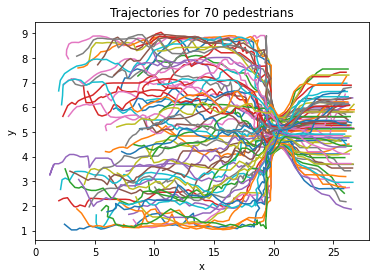

In [737]:
fig, ax = plt.subplots()
plot_trajectories(ped_traj_df_formatted_reduced, 70, ax)

# Finding Center of Gravity from Actual Data

In [738]:
center_of_gravity = find_center_of_gravity(ped_traj_df_formatted_reduced)

100%|████████████████████████████████████████████████████████████████████████████████| 143/143 [00:06<00:00, 21.05it/s]


(Text(0.5, 0, 'x'), Text(0, 0.5, 'y'), Text(0.5, 1.0, 'Center of Gravity'))

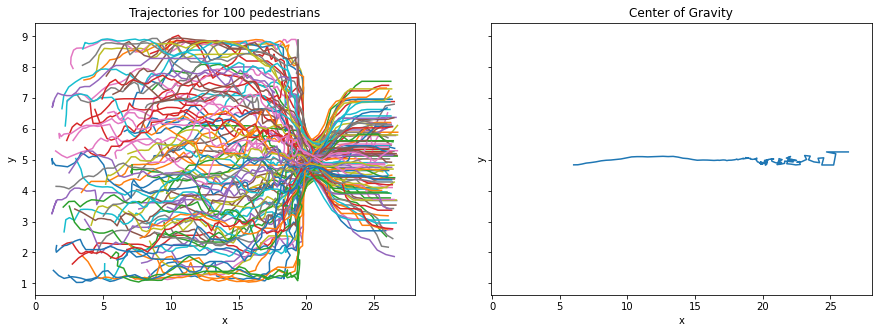

In [739]:
fig, axs = plt.subplots(1, 2, figsize=(15,5), sharex=True, sharey=True)
plot_trajectories(ped_traj_df_formatted_reduced, 100, axs[0])
axs[1].plot(center_of_gravity[:,0], center_of_gravity[:,1])
axs[1].set_xlabel('x'), axs[1].set_ylabel('y'), axs[1].set_title("Center of Gravity")
# fig.savefig('figures/ped_traj_and_cog_actual.png')

## Predicting the center of gravity - Polynomial Dictionary of Observables

In [740]:
t_eval = np.arange(0.4, len(center_of_gravity)*0.4, 0.4)
cog_arr = np.concatenate([np.ones_like(t_eval.reshape(t_eval.shape[0],-1)), t_eval.reshape(t_eval.shape[0],-1), center_of_gravity[:-1], center_of_gravity[1:]], axis=1)
cog_df = pd.DataFrame(cog_arr, columns=['ID', 'time', 'x1', 'x2', 'y1', 'y2'])
cog_df

,ID,time,x1,x2,y1,y2
0,1.0,0.4,6.033272,4.840303,6.341797,4.842538
1,1.0,0.8,6.341797,4.842538,6.645377,4.865885
2,1.0,1.2,6.645377,4.865885,6.956889,4.896992
3,1.0,1.6,6.956889,4.896992,7.300714,4.913372
4,1.0,2.0,7.300714,4.913372,7.680693,4.937837
...,...,...,...,...,...,...
137,1.0,55.2,24.717862,5.258363,25.038964,5.258363
138,1.0,55.6,25.038964,5.258363,25.360065,5.258363
139,1.0,56.0,25.360065,5.258363,25.681167,5.258363
140,1.0,56.4,25.681167,5.258363,26.002269,5.258363


In [741]:
polynomial_observables = Polynomials(3)
edmd = EDMD(cog_df, 2, polynomial_observables)
edmd.fit()

In [742]:
initial_values = cog_df.groupby('ID').first().iloc[:,1:-2]
initial_values.insert(0,'ID',initial_values.index)
initial_values.insert(1,'time', 0)
cog_pred = edmd.predict(initial_values, t_range=t_eval)
cog_pred

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]


,ID,time,x1,x2
1.0,1.0,0.0,6.033272,4.840303
0.0,1.0,0.8,6.324920,4.848155
0.0,1.0,1.2,6.628389,4.860085
0.0,1.0,1.6,6.946934,4.877010
0.0,1.0,2.0,7.283470,4.899410
...,...,...,...,...
0.0,1.0,55.2,22.882761,4.958162
0.0,1.0,55.6,22.911073,4.958670
0.0,1.0,56.0,22.939255,4.959176
0.0,1.0,56.4,22.967308,4.959681


(Text(0.5, 0, 'x'),
 Text(0, 0.5, 'y'),
 Text(0.5, 1.0, 'Predicted Center of Gravity with Polynomial Dict of Observables'))

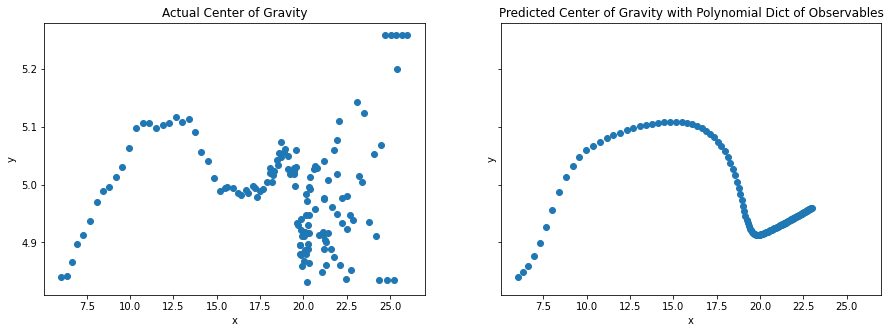

In [743]:
fig, axs = plt.subplots(1, 2, figsize=(15,5), sharex=True, sharey=True)
axs[0].scatter(cog_df.iloc[:,2], cog_df.iloc[:,3])
axs[0].set_xlabel('x'), axs[0].set_ylabel('y'), axs[0].set_title("Actual Center of Gravity")
axs[1].scatter(cog_pred.iloc[:,2], cog_pred.iloc[:,3])
axs[1].set_xlabel('x'), axs[1].set_ylabel('y'), axs[1].set_title("Predicted Center of Gravity with Polynomial Dict of Observables")
# fig.savefig('figures/predicted_traj_poly.png')

## MSE Loss

In [744]:
print(f"MSE combined is {mse_all_traj(cog_df, cog_pred)}")

MSE combined is 0.6092815346448293


## COG with DMD

In [668]:
identity_observables = Identity()
dmd = EDMD(cog_df, 2, identity_observables)
dmd.fit()
initial_values = cog_df.groupby('ID').first().iloc[:,1:-2]
initial_values.insert(0,'ID',initial_values.index)
initial_values.insert(1,'time', 0)
cog_pred_dmd = dmd.predict(initial_values, t_range=t_eval)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


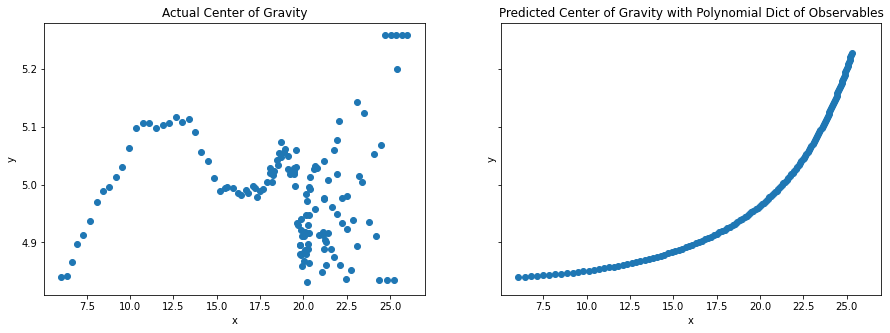

In [669]:
fig, axs = plt.subplots(1, 2, figsize=(15,5), sharex=True, sharey=True)
axs[0].scatter(cog_df.iloc[:,2], cog_df.iloc[:,3])
axs[0].set_xlabel('x'), axs[0].set_ylabel('y'), axs[0].set_title("Actual Center of Gravity")
axs[1].scatter(cog_pred_dmd.iloc[:,2], cog_pred_dmd.iloc[:,3])
axs[1].set_xlabel('x'), axs[1].set_ylabel('y'), axs[1].set_title("Predicted Center of Gravity with Polynomial Dict of Observables")
fig.savefig('figures/predicted_traj_identity.png')

In [670]:
print(f"MSE combined is {mse_all_traj(cog_df, cog_pred_dmd)}")

MSE combined is 1.9461264042979356


# EDMD To Predict All Trajectories - Polynomial Dictionary of Observables 

In [745]:
polynomial_observables = Polynomials(2)
polynomial_observables.fit(ped_traj_df_formatted_reduced.iloc[:,:-2])
polynomial_observables.segregate_observables_from_variable(polynomial_observables.fit(ped_traj_df_formatted_reduced.iloc[:,:-2]))

,ID,time,x1^0x2^1,x1^0x2^2,x1^1x2^0,x1^1x2^1,x1^2x2^0
0,1,0.4,4.204623,17.678859,5.890973,24.769322,34.703560
1,1,0.8,4.177381,17.450516,6.193803,25.873877,38.363193
2,1,1.2,4.210065,17.724646,6.378041,26.851966,40.679406
3,1,1.6,4.275590,18.280666,6.508260,27.826648,42.357446
4,1,2.0,4.318879,18.652713,6.722985,29.035756,45.198524
...,...,...,...,...,...,...,...
7666,100,47.2,4.471115,19.990873,24.517379,109.620031,601.101877
7667,100,47.6,4.471115,19.990873,24.886801,111.271758,619.352849
7668,100,48.0,4.471115,19.990873,25.256222,112.923484,637.876766
7669,100,48.4,4.471115,19.990873,25.625644,114.575211,656.673627


In [767]:
polynomial_observables = Polynomials(2)
edmd = EDMD(ped_traj_df_formatted_reduced, 2, polynomial_observables)
edmd.fit()
t_eval = np.arange(0.4, 30, delta_t)

In [768]:
initial_values = ped_traj_df_formatted_reduced.groupby('ID').first().iloc[:,1:-2]
initial_values.insert(0,'ID',initial_values.index)
initial_values.insert(1,'time', 0)
traj_pred = edmd.predict(initial_values, t_range=t_eval)

  7%|█████▋                                                                            | 7/100 [00:03<00:51,  1.82it/s]F:\Google Drive Waleed\Waleed\Masters\3rd Semester\Crowd Modelling and Simulation\final_project\ml_cms_final_project\EDMD.py:128: RuntimeWarning: invalid value encountered in matmul
  eigenfunctions = self.build_dict_from_data(data).to_numpy() @ self.eigenvectors_right
  8%|██████▌                                                                           | 8/100 [00:04<00:51,  1.79it/s]F:\Google Drive Waleed\Waleed\Masters\3rd Semester\Crowd Modelling and Simulation\final_project\ml_cms_final_project\EDMD.py:128: RuntimeWarning: invalid value encountered in matmul
  eigenfunctions = self.build_dict_from_data(data).to_numpy() @ self.eigenvectors_right
 12%|█████████▋                                                                       | 12/100 [00:06<00:50,  1.76it/s]F:\Google Drive Waleed\Waleed\Masters\3rd Semester\Crowd Modelling and Simulation\final_project\ml_cms_

KeyboardInterrupt: 

In [ ]:
traj_pred_formatted = remove_extrapolated_data(traj_pred, ped_traj_df_formatted_reduced)
traj_pred_formatted#.groupby("ID").count()

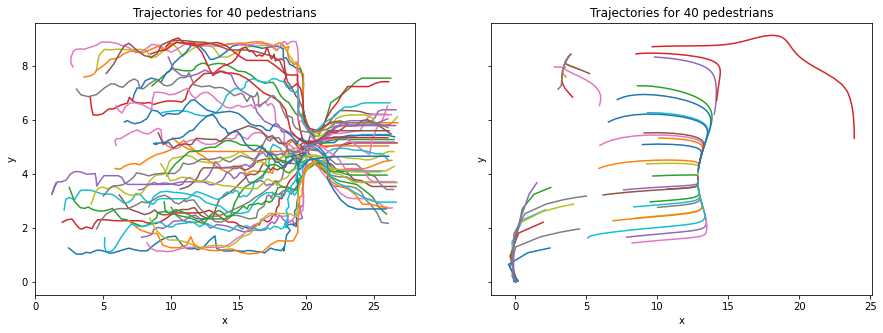

In [766]:
fig, axs = plt.subplots(1, 2, figsize=(15,5), sharex=False, sharey=True)
no_peds = 40
plot_trajectories(ped_traj_df_formatted_reduced, no_peds, axs[0])
plot_trajectories(traj_pred_formatted, no_peds, axs[1])
# fig.savefig('figures/edmd_traj_pred.png')

100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:03<00:00, 22.85it/s]


(Text(0.5, 0, 'x'),
 Text(0, 0.5, 'y'),
 Text(0.5, 1.0, 'Predicted Center of Gravity with Polynomial Dict of Observables'))

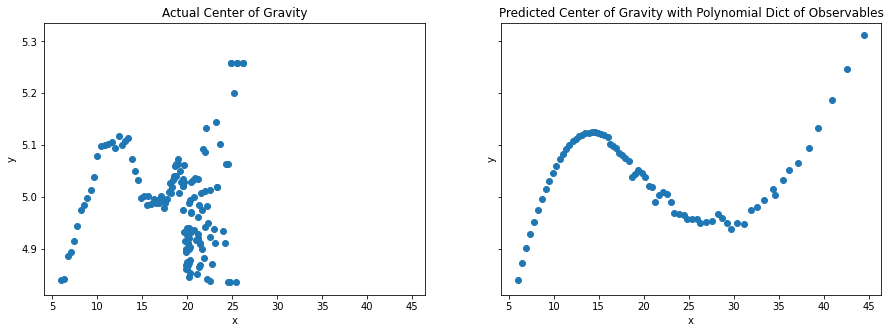

In [609]:
# center_of_gravity = find_center_of_gravity(ped_traj_df_formatted)
center_of_gravity_edmd = find_center_of_gravity(traj_pred_formatted)
fig, axs = plt.subplots(1, 2, figsize=(15,5), sharex=True, sharey=True)
axs[0].scatter(center_of_gravity[:,0], center_of_gravity[:,1])
axs[0].set_xlabel('x'), axs[0].set_ylabel('y'), axs[0].set_title("Actual Center of Gravity")
axs[1].scatter(center_of_gravity_edmd[:,0], center_of_gravity_edmd[:,1])
axs[1].set_xlabel('x'), axs[1].set_ylabel('y'), axs[1].set_title("Predicted Center of Gravity with Polynomial Dict of Observables")

In [189]:
print(f"MSE of center of gravity is {np.sum((center_of_gravity - center_of_gravity_edmd[:center_of_gravity.shape[0],:])**2) / center_of_gravity_edmd.shape[0]:0.5f}")

MSE of center of gravity is 28.88005


# Checking Results from Datafold 

In [748]:
tsc_traj = TSCDataFrame(ped_traj_df_formatted_reduced.set_index(['ID', 'time']))
tsc_traj = tsc_traj[['x1', 'x2']]
tsc_traj

feature          x1        x2
ID  time                     
1   0.4    5.890973  4.204623
    0.8    6.193803  4.177381
    1.2    6.378041  4.210065
    1.6    6.508260  4.275590
    2.0    6.722985  4.318879
...             ...       ...
100 47.2  24.517379  4.471115
    47.6  24.886801  4.471115
    48.0  25.256222  4.471115
    48.4  25.625644  4.471115
    48.8  25.995066  4.471115

[7671 rows x 2 columns]

In [760]:
from datafold.dynfold.transform import TSCPolynomialFeatures, TSCRadialBasis
from datafold.pcfold import GaussianKernel

# dict_step = [
#     (
#         "polynomial",
#         TSCPolynomialFeatures(degree=2),
#     )
# ]

dict_step = [
    (
        "rbf",
        TSCRadialBasis(
            kernel=GaussianKernel(epsilon=0.08), center_type="initial_condition"
        ),
    )
]

edmd_poly = datafold_EDMD(dict_steps=dict_step, include_id_state=True).fit(X=tsc_traj)
edmd_poly_values = edmd_poly.predict(tsc_traj.initial_states())

In [761]:
edmd_poly.transform(tsc_traj)

feature          x1        x2      rbf0          rbf1          rbf2  \
ID  time                                                              
1   0.4    5.890973  4.204623  1.000000  3.796592e-46  3.690851e-53   
    0.8    6.193803  4.177381  0.561131  2.195638e-42  1.480310e-59   
    1.2    6.378041  4.210065  0.226977  1.613973e-39  3.202452e-64   
    1.6    6.508260  4.275590  0.089547  6.488491e-37  4.201778e-68   
    2.0    6.722985  4.318879  0.012178  6.772446e-34  5.273433e-74   
...             ...       ...       ...           ...           ...   
100 47.2  24.517379  4.471115  0.000000  0.000000e+00  0.000000e+00   
    47.6  24.886801  4.471115  0.000000  0.000000e+00  0.000000e+00   
    48.0  25.256222  4.471115  0.000000  0.000000e+00  0.000000e+00   
    48.4  25.625644  4.471115  0.000000  0.000000e+00  0.000000e+00   
    48.8  25.995066  4.471115  0.000000  0.000000e+00  0.000000e+00   

feature           rbf3      rbf4      rbf5          rbf6          rbf7  ...  \
ID  time                                                                ...   
1   0.4   1.071152e-10  0.001377  0.010073  8.738909e-53  1.401079e-42  ...   
    0.8   5.806647e-08  0.003302  0.005584  5.034900e-46  1.190772e-45  ...   
    1.2   9.430883e-07  0.001764  0.003794  1.545544e-42  8.909465e-47  ...   
    1.6   3.320739e-06  0.000503  0.003398  1.568911e-40  7.484879e-47  ...   
    2.0   3.172807e-05  0.000089  0.000894  6.466856e-37  1.808113e-48  ...   
...                ...       ...       ...           ...           ...  ...   
100 47.2  0.000000e+00  0.000000  0.000000  0.000000e+00  0.000000e+00  ...   
    47.6  0.000000e+00  0.000000  0.000000  0.000000e+00  0.000000e+00  ...   
    48.0  0.000000e+00  0.000000  0.000000  0.000000e+00  0.000000e+00  ...   
    48.4  0.000000e+00  0.000000  0.000000  0.000000e+00  0.000000e+00  ...   
    48.8  0.000000e+00  0.000000  0.000000  0.000000e+00  0.000000e+00  ...   

feature          rbf90         rbf91         rbf92         rbf93  \
ID  time                                                           
1   0.4   3.191775e-18  5.185087e-26  5.228359e-46  1.848358e-42   
    0.8   3.599810e-15  6.872185e-25  4.381483e-51  2.860630e-36   
    1.2   5.114132e-14  3.002537e-25  4.197843e-55  6.098607e-33   
    1.6   9.944316e-14  2.549543e-26  1.155313e-58  6.960053e-31   
    2.0   7.646632e-13  3.121647e-27  7.907341e-64  1.963942e-27   
...                ...           ...           ...           ...   
100 47.2  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
    47.6  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
    48.0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
    48.4  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
    48.8  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

feature          rbf94         rbf95         rbf96         rbf97  \
ID  time                                                           
1   0.4   6.095596e-17  6.433805e-53  1.640246e-52  9.310964e-63   
    0.8   1.626093e-14  3.672041e-60  6.210747e-60  3.409898e-60   
    1.2   7.850076e-13  2.091814e-64  1.049434e-64  1.001468e-57   
    1.6   2.211958e-11  3.479660e-67  3.218918e-68  4.055682e-55   
    2.0   8.832076e-10  1.694301e-72  3.433752e-74  1.574655e-52   
...                ...           ...           ...           ...   
100 47.2  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
    47.6  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
    48.0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
    48.4  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
    48.8  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

feature          rbf98         rbf99  
ID  time                              
1   0.4   1.357764e-68  2.417818e-62  
    0.8   1.980548e-73  2.009820e-69  
    1.2   1.941100e-75  1.679205e-74  
    1.6   5.665054e-76  1.130566e-78  
    2.0   1.341512e-78  4.684689e-85  
...  

Text(0, 0.5, 'y')

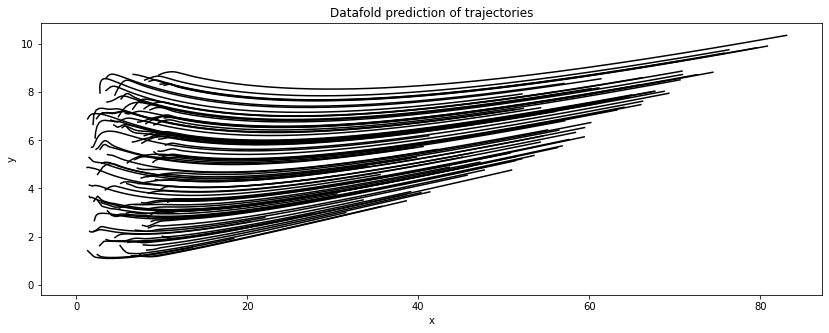

In [762]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5))

for _id, df in edmd_poly_values.itertimeseries():
    ax.plot(df["x1"].to_numpy(), df["x2"].to_numpy(), 0.1, c="black")
ax.set_title('Datafold prediction of trajectories')
ax.set_xlabel('x'); ax.set_ylabel('y')

# fig.savefig('figures/edmd_traj_pred_datafold.png')